# Multi-agent workflow

<a target="_blank" href="https://colab.research.google.com/github/olivierSorba/iens2024labs/blob/main/coding_agent.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## General setup

Getting our API keys

In [3]:
# %load ./credentials_cell.py

Installing missing packages (should not be required)

In [4]:
# ! pip install -U cryptography gradio python-dotenv tavily-python  langchain==0.3.0	 langchain-community==0.3.0	 langchain-core==0.3.0	 langgraph>=0.2.20	 langchain-mistralai==0.2.0	 langchain-openai==0.2.0	 langgraph-checkpoint-sqlite

Useful environment variables

In [5]:
import os
#os.environ['MISTRAL_API_KEY'] = os.environ['CODESTRAL_API_KEY']
os.environ['TOKENIZERS_PARALLELISM'] = 'true'
# this prevents langraph to report to a LangSmith company server. Activate to see the tracing logs online
os.environ['LANGCHAIN_TRACING_V2'] = 'false'
# os.environ["LANGCHAIN_PROJECT"] = "iens2024lab"

DO_TESTS = False

## imports

In [6]:
import base64
import numpy as np
import pickle
import os
from io import BytesIO
from operator import itemgetter
from typing import Annotated, Dict, List, TypedDict
from IPython.display import Image as ipImage, display

from IPython.display import Image, display
from PIL import Image
from pydantic import BaseModel, Field

from langchain_core.messages import HumanMessage
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_mistralai import ChatMistralAI
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.checkpoint.memory import MemorySaver


### Utility functions

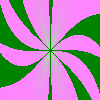

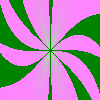

In [7]:
def array_to_b64(arr):
    """convert a numpy array to a base64 string
    """
    buff = BytesIO()
    pil_img = Image.fromarray(np.array(arr))
    pil_img.save(buff, format="PNG")
    return base64.b64encode(buff.getvalue()).decode("utf-8")

def b64_to_array(b64_str):
    """ convert a base64 string to a numpy array"""
    return np.array(Image.open(BytesIO(base64.b64decode(b64_str))))

def b64_to_Image(b64_str):
    """ convert a base64 string to a PIL Image"""
    return Image.open(BytesIO(base64.b64decode(b64_str)))

def dummy_image(h=100, l=100):
    """ create a dummy image with a white square in the middle"""
    dummy_array = np.zeros((h, l, 3), dtype=np.uint8)
    x, y = np.indices(dummy_array.shape[:2])
    x, y  = x - h/2, y - l/2
    r = np.sqrt(x**2+y**2**2)
    r0 = np.sqrt(h**2+l**2)/2
    theta = np.arctan2(y, x)
    shape =  r0/(3*r+r0) * (np.sin(4*(theta)+r/r0/20)**2)
    dummy_array[:,:,0] = shape*125
    dummy_array[:,:,1] = (1-shape)*125
    dummy_array[:,:,2] = shape*125
    return Image.fromarray((dummy_array*255).astype(np.uint8))

img = dummy_image()
#img = Image.open("./immages/dummy.png")
display(img)
b64_str = array_to_b64(np.array(img))
clone_array = b64_to_array(b64_str)
clone_image = Image.fromarray(clone_array)
display(clone_image)

def test_code_result(question, shape, result):
    print(f"question: {question}")
    print(f"shape: {shape}")
    print("-"*80)
    global_scope = {}
    try:
        cleaned_code = result.code.replace("\\n", "\n")
        exec(f"{result.imports}\n{cleaned_code}", global_scope)
        display(Image.fromarray((global_scope['output']*255).astype(np.uint8)))
    except Exception as e:
        print(f"could not find or display output. (error: {e})")
    print("-"*80)
    for k, v in result.dict().items():
        print(f"{k}: {v}")

def show_vision_assessment(description, result, b64image_data):
    display(b64_to_Image(b64_str))
    print(f"description: {description}")
    for k, v in result.dict().items():
        print(f"{k}: {v}")


## Choose our models and their hyperparameters

In [8]:
seed = 15112024
# Coding model

# code_model_name = "codestral-latest"
#code_model_name = "open-codestral-mamba"
#code_provider = "Mistral"

code_model_name = "gpt-4o-mini"
code_provider = "Openai"

if code_provider == "Mistral":
    code_llm = ChatMistralAI(model=code_model_name, temperature=0, seed=seed)
elif code_provider == "Openai":
    code_llm = ChatOpenAI(model=code_model_name, temperature=0, seed=seed)
                          #endpoint="https://codestral.mistral.ai/v1",
                          #mistral_api_key=os.environ['MISTRAL_API_KEY'])


# Vision model

vision_model_name = "pixtral-12b-2409"
vision_provider = "Mistral"
if vision_provider == "Mistral":
    vision_llm = ChatMistralAI(model=vision_model_name, temperature=0)

## Simple codechain (no graph yet)

### Test with structured output.

In [9]:
CODE_SYSTEM_PROMPT = """
Your are a very competent coding assistant.
Your task is to create a Python program that draws in a bitmap according to the description provided by the user.

First think of a way to mathematically represent the description in terms of geometry, perspective and colors.

Then write a program that should:
produce a python function to assign the result of the mathematical representation to a numpy bitmap.
- Produce a three dimensional float numpy array representing a bitmap of the shape provided by the user.
- If the user does not provide a shape, create a (100,100,3) float numpy array.
- assign the result of this function name this array `output`.
- apply the mathematical representation to the numpy array.

Finally review your code and correct it to provide a final answer in a structured way.
Structure your answer: 1) a prefix describing the code solution, 2) the imports, 3) the functioning code block.

Requirements:
- think step by step
- take into accound the provided hints and criticism if the are provide by the user
- briefly comment the code to explain your decisions
- use functions to modularize the code.
- respect the requested shape. If the user does not provide a shape, use (100,100,3) as default.
- respect the float output type and [0,1] value range.
- pay strict attention to dimension of the arrays in assignments
- try to proportionate the dimensions of what you draw to the shape of the bitmap
- do not use input() or any user input at the time of execution.
- do not attempt to display the output.
- do not use any external library other than numpy.
- the first code line should be `import numpy as np`
- the last code line should start with `output =`

Example:
user: description : a red line from (10,10) to (90,90)
user: shape : (100,100,3)
assistant: {{
prefix: "I will create a function to draw a line in a numpy array using a linear interpolation between two points.",
imports:
```
import numpy as np
```,
code:
```
def draw_line(shape, start, end, color):
    # draw a line in the numpy array
    output = np.zeros(shape, dtype=np.float32)
    n_steps = max(end[1]-start[1],end[0]-start[0])
    steps = np.linspace(start, end, n_steps)
    c = np.array(color)
    for i in range(n_steps):
        x = int(steps[i,0])
        y = int(steps[i,1])
        output[x,y,:] = c
    return output
# last line as requested
output = draw_line(shape = (100,100,3), start=(10,10), end=(90,90), color=(1,0,0))
```}}
"""


In [10]:
# Data model
class code(BaseModel):
    """Schema for code solutions."""
    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")

# LLM
code_gen_chain = code_llm.with_structured_output(code, include_raw=False)
# Test
if DO_TESTS:
    description= "red donut"
    shape= (100,100,3)
    messages = [("system",CODE_SYSTEM_PROMPT),
                ("user", f"description: {description}, shape: {shape}."),]
    result = code_gen_chain.invoke(messages)
    test_code_result(description, shape, result)


with a template for the prompt

In [11]:
code_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", CODE_SYSTEM_PROMPT),
        ("human", "description: {description}, shape:{shape}"),
        ("placeholder", "{messages}")
        # or equivalently:
        #    MessagesPlaceholder(variable_name="messages", optional=True)
    ]
)
# print(code_prompt.get_input_jsonschema()['properties'])

# structured chain:  prompt -> model -> structured output
code_gen_chain =   code_prompt | code_llm.with_structured_output(code, include_raw=False)

# test the chain
if DO_TESTS:
    result = code_gen_chain.invoke({"description": "red donut", "shape": (100,100,3)})
    test_code_result("red donut", (100,100,3), result)

### Assessing an image

In [12]:
VISION_SYTEM_PROMPT ="""You will Assess how much the provided image conforms to the description provided by the user.
                      Answer in a structured way with a note from 0 to 100 and a hint to improve the representation.
                      Express the hint in precise technical or mathematical terms.
                      Use pixel locations, colors, shapes, textures, and other visual features to justify your assessment.
                      Express your answer as a JSON object with the keys "note" and "hint".
                      Example: {{note:50, hint:"a staircase should have steps and the image is too dark"}}"""

In [13]:
# Data model
class vision_assessment(BaseModel):
    """Schema for code solutions to questions about LCEL."""
    note: int = Field(description="Assesment of the fidelity of the user provided description. 1 to 100")
    hint: str = Field(description="Hint as to improve the image to match the description")

# LLM
vision_gen_chain = vision_llm.with_structured_output(vision_assessment, include_raw=False)

# Test
if DO_TESTS:
    question = "Is this an starlike shape ?"
    messages = [("system", VISION_SYTEM_PROMPT),
                ("user", question),
                ("user", [
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/png;base64,{b64_str}"},
                    }
                ])]

    result = vision_gen_chain.invoke(messages)
    show_vision_assessment(question, result, b64_str)

Vision assessment with structured input

In [14]:
vision_prompt = ChatPromptTemplate.from_messages(
    [
        ("system",    VISION_SYTEM_PROMPT),
        ("user", [
                    {"text" :"description: {description}"},
                    {"type": "image_url", "image_url": {"url": "data:image/{format};base64,{image_data}"}}
                 ],
        )
    ]
)
#print(vision_prompt.get_input_jsonschema()['properties'])

# structured chain:  prompt -> model -> structured output
vision_gen_chain = vision_prompt | vision_llm.with_structured_output(vision_assessment, include_raw=False)

# testing chain
if DO_TESTS:
    result = vision_gen_chain.invoke(input={"description":"starlike object", "image_data":b64_str, "format":"png"})
    show_vision_assessment(question, result, b64_str)

## Graph

- We continue with building a workflow as a graph using [LangGraph](https://langchain-ai.github.io/langgraph/).

- a graph as nodes representing tasks and edges representing data flow


### Graph state

The graph `state` schema contains key:value entries that we want to:
* Pass to each node in our graph
* Optionally, modify in each node of our graph

In [15]:


class GraphState(TypedDict):

    """
    Represents the state of our graph.

    Attributes:
        requested_description : Description requested by the user
        requested_shape : Shape requested by the user
        errors : cumulative error count on code check. reset when passing
        messages : With user question, error messages, reasoning
        code_solution_import : Code solution imports part
        code_solution_code : Code solution code part
        iterations : Number of tries
        user_satisfaction : User satisfaction provided by the user
        code_output : Code output provided by the code node
        b64_image_output : Image output provided by the check_code node
        vision_note : Vision note provided by the vision node
        vision_hint : Vision hint provided by the vision node
        vision_improvement : last increment in vision_note
    """

    requested_description: str
    requested_shape: tuple
    errors: int
    # add_message will update old message list with new messages and updated messages. others unchanged.
    messages: Annotated[list[AnyMessage], add_messages]
    code_solution_imports: str
    code_solution_code: str
    iterations: int
    user_satisfaction : str
    code_output : str
    b64_image : str
    vision_note : int = 0
    vision_improvement : int = 0


### Functions to be called by graph nodes

#### Generation node

In [16]:
def generate(state: GraphState):
    """
    Generate a code solution

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, code_solution
    """

    print("---GENERATING CODE SOLUTION---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    requested_description = state["requested_description"]
    requested_shape = state["requested_shape"]
    errors = state["errors"]

    # Increment before branching and returns
    iterations +=  1
    new_messages = []
    # Solution
    try:
        #TODO: limit sent messages
        code_solution = code_gen_chain.invoke({"shape":requested_shape,
                                            "description":requested_description,
                                            "messages":messages})
    except Exception as e:
        new_messages += [("human", f"Last code generation returned an error: {e}")]
        errors += 1
        return {"code_solution_imports": "raise Exception('error in code generation')",
                "code_solution_code": "",
                "messages": new_messages,
                "iterations": iterations,
                "errors": errors
                }

    new_messages+= [
        ("assistant",
          f"Here is my attempt to solve the problem: \nprefix: {code_solution.prefix} \nimports: {code_solution.imports} \ncode: {code_solution.code}",
        )
    ]

    # Update state
    return {"code_solution_imports": code_solution.imports,
            "code_solution_code": code_solution.code,
            "messages": new_messages,
            "iterations": iterations,
            }



#### Code check node

In [17]:
def code_check(state: GraphState):
    """
    Check code and records output

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): update to keys: errors, code_output
    """

    print("---CHECKING CODE---")


    # State
    new_messages = []
    code_solution_imports = state["code_solution_imports"]
    code_solution_code = state["code_solution_code"]
    iterations = state["iterations"]
    requested_shape = state["requested_shape"]
    errors = state["errors"]

    print(
    "Current solution:\n"
    "-----------\n"
    "imports:\n"
    f"{code_solution_imports}\n"
    "code:\n"
    f"{code_solution_code}\n"
    "-----------------------\n"
    )

    # Check imports
    global_scope = {}
    # Reflect instruction in case of error
    reflect_instruction =  "Reflect on this error and your prior attempt to solve the problem. (1) State what you think went wrong with the prior solution and (2) try to solve this problem again. Return the FULL SOLUTION. Structure the output with a prefix, imports, and code block."
    try:
        exec(code_solution_imports, global_scope)
    except Exception as e:
        print("---CODE IMPORT CHECK: FAILED---")
        new_messages+= [("user", f"Your solution failed the import test. Here is the error: {e}. Reflect on this error and your prior attempt to solve the problem. (1) State what you think went wrong with the prior solution and (2) try to solve this problem again. Return the FULL SOLUTION. Use the code tool to structure the output with a prefix, imports, and code block:")]
        errors+=1
        return {
            "messages": new_messages,
            "errors": errors,
        }
    # Check execution
    try:
        combined_code = f"{code_solution_code}\n{code_solution_code}"
        # Use a shared scope for exec
        exec(code_solution_code, global_scope)
    except Exception as e:
        print("---CODE BLOCK CHECK: FAILED---")
        new_messages+= [("user", f"Your solution failed the code execution test: {e}. {reflect_instruction})")]
        errors+=1
        return {
            "messages": new_messages,
            "errors": errors,
        }
    if "output" not in global_scope or global_scope["output"].shape != requested_shape:
        print("---CODE OUTPUT CHECK: FAILED---")
        new_messages+= [("user",
                          f"Your solution failed to produce an `output` variable of shape {requested_shape}. {reflect_instruction}"
                      )]
        errors+=1
        return {
            "messages": new_messages,
            "errors": errors,
        }
    # No errors
    print("---NO CODE TEST FAILURES---Displaying output")
    int_output = (global_scope["output"]*255).astype(np.uint8)
    b64_image_output = array_to_b64(int_output)
    display(Image.fromarray(int_output))

    return {
        "b64_image": b64_image_output,
        "errors": 0,
    }


#### Vision Node

In [18]:

def vision_check(state: GraphState):
    """
    Generate an assessment  of the code output

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key (added/updated) to state, vision_note, vision hint, messages
    """

    print("---GENERATING VISION LLM ASSESSMENT---")

    # State
    user_messages = []
    b64_image_output = state["b64_image"]
    last_vision_note = state["vision_note"]
    requested_description = state["requested_description"]

    # vision_messages = [("user", question),
    #                    ("user", [{"type": "image_url", "image_url": {"url": f"data:image/png;base64, {b64_image_output}"}}])]
    vision_result = vision_gen_chain.invoke(input={"description":requested_description,
                                                   "image_data":b64_image_output,
                                                   "format":"png"})

    # Solution
    vision_note = int(vision_result.note)
    vision_improvement = vision_result.note - last_vision_note
    user_messages += [HumanMessage(f"Your solution is noted by an independent assessor: {vision_note}/100. Here is an improvement hint : {vision_result.hint}")]

    # Update state
    # the hint is stored in the messages
    return {"vision_note": vision_note,
            "vision_improvement": vision_improvement,
            "messages": user_messages}



#### User input node

In [19]:

### Conditional edges
def user_satisfaction_check(state: GraphState):
    """
    Get user satisfaction
    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, user_satisfaction
    """
    new_messages = []

    user_satisfaction = input("Are you satisfied with the code and the image ? (yes/no): ").lower()
    if user_satisfaction.startswith("y"):
        user_satisfaction = "yes"
        print("---USER SATISFIED---")
    else:
        print("---USER NOT SATISFIED---")
        user_satisfaction = "no"
        hint = input("Please provide a hint to improve the code: ")
        new_messages+= [HumanMessage(content=f"Your solution is not perfect yet. Here is a hint: {hint}. Reflect on this hint and your prior attempt to improve your solution. (1) State what you think went wrong with the prior solution and (2) try to solve this problem again. Return the FULL SOLUTION. Use the code tool to structure the output with a prefix, imports, and code block:")]

    # Update state
    return {
        "messages": new_messages,
        "user_satisfaction": user_satisfaction
    }




### Edges

#### Conditional edges

##### Ask user decision edge

In [20]:
def decide_to_ask_user(state: GraphState):
    """
    Determines whether to finish.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    iterations = state["iterations"]
    vision_note = state["vision_note"]
    vision_improvement = state["vision_improvement"]

    # TODO: locate somewhere else in a context
    first_ask_user_iteration = 3
    improvement_threshold = 0
    vision_note_threshold = 90

    if iterations >= max_iterations:
        print(f"---DECISION: bypass user, as {iterations} >= {max_iterations}")
        return "after_checks"
    # we are in a good zone
    if vision_note >= vision_note_threshold:
        print(f"---DECISION: ask user, as {vision_note}>={vision_note_threshold}")
        return "user_satisfaction_check"
    # we are in a mediocre zone, ask for help
    elif iterations >= 3 and vision_improvement <= 0:
        print(f"---DECISION: ask user, as iteration={iterations} and vision_improvement={vision_improvement}<={improvement_threshold}")
        return "user_satisfaction_check"

    print(f"---DECISION: bypass user, with iteration={iterations}, vision_note={vision_note}, vision_improvement={vision_improvement}")
    return "after_checks"




##### Decide to finish edge

In [21]:
def decide_to_finish(state: GraphState):
    """
    Determines whether to finish.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    iterations = state["iterations"]
    user_satisfaction = state["user_satisfaction"]

    if user_satisfaction == "yes" :
        print("---DECISION: FINISH---:user satisfied")
        return "end"
    if iterations >= max_iterations:
        print(f"---DECISION: FINISH---: reached iteration {iterations}/{max_iterations}")
        return "end"
    else:
        print("---DECISION: RE-TRY SOLUTION---")
        return "generate"


##### Goto vision check edge

In [22]:
def decide_to_call_vision_check(state: GraphState):
    """
    Determines whether to finish.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    iterations = state["iterations"]
    errors = state["errors"]
    if errors == 0 :
        # we want to see the eval event at the last iteration
        print("---DECISION: VISION CHECK---")
        return "vision_check"
    else:
        if iterations >= max_iterations:
            print(f"---DECISION: FINISH---: reached iteration {iterations}/{max_iterations}")
            return "end"
        elif errors >= 2:
                print("---DECISION: {errors} consecutive code failures: Ask for user help---")
                return "user_satisfaction_check"
        else:
            print("---DECISION: RE-TRY SOLUTION---")
            return "generate"

### Building the graph

#### Define nodes and edges and put it all together

- We'll add persistence to the graph using [a checkpointer](https://langchain-ai.github.io/langgraph/concepts/persistence/).

In [23]:


# Define the graph
builder = StateGraph(GraphState)

# Define the nodes
builder.add_node("generate", generate)  # code_solution solution
builder.add_node("check_code", code_check)  # check code
builder.add_node("vision_check", vision_check)  # check vision
builder.add_node("user_satisfaction_check", user_satisfaction_check)  # check user satisfaction
builder.add_node("after_checks", lambda x: x)  # end



# Build graph
builder.set_entry_point("generate")
builder.add_edge("generate", "check_code")
builder.add_edge("user_satisfaction_check", "after_checks")

builder.add_conditional_edges(
    source= "check_code",
    path = decide_to_call_vision_check,
    path_map={"vision_check": "vision_check",
              "end":END,
              "generate": "generate",
              "user_satisfaction_check":"user_satisfaction_check"},
)

builder.add_conditional_edges(
    source= "vision_check",
    path = decide_to_ask_user,
    path_map={"after_checks": "after_checks", "user_satisfaction_check": "user_satisfaction_check", }
)
builder.add_conditional_edges(
    source= "after_checks",
    path = decide_to_finish,
    path_map={"end": END, "generate": "generate", }
)

checkpointer = MemorySaver()
graph = builder.compile(checkpointer=checkpointer)


#### A representation of the graph structure

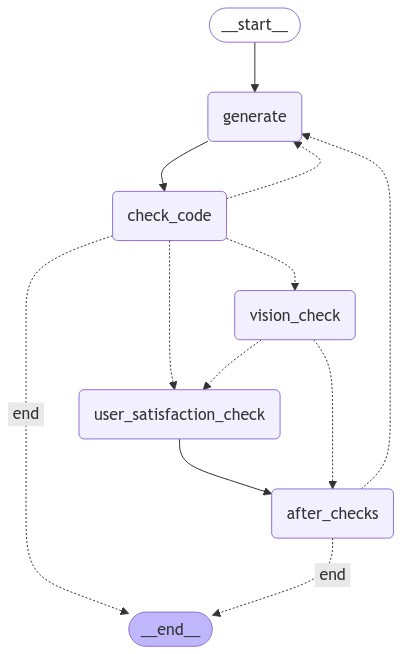

In [24]:
graph_rep = graph.get_graph(xray=True)
graph_image = ipImage(graph_rep.draw_mermaid_png())
display(graph_image)

### Running the graph

#### Utility function to limit redondant printing

In [25]:
### Utilities
def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

#### Actually running the graph

================================ Human Message =================================

hint: in the code block, define a 'draw_line' function, a 'draw_face' and then a 'draw_cube' function.
---GENERATING CODE SOLUTION---
================================== Ai Message ==================================

Here is my attempt to solve the problem: 
prefix: I will create functions to draw a colorful spiral pattern in a numpy array, including functions for drawing lines, faces, and cubes. 
imports: import numpy as np 
code: def draw_line(output, start, end, color):
    # Draw a line in the numpy array using Bresenham's algorithm
    x0, y0 = start
    x1, y1 = end
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
     ... (truncated)
---CHECKING CODE---
Current solution:
-----------
imports:
import numpy as np
code:
def draw_line(output, start, end, color):
    # Draw a line in the numpy array using Bresenham's algorithm
    x0, y0 = start
    x1, y1 = end
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    

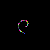

---DECISION: VISION CHECK---
---GENERATING VISION LLM ASSESSMENT---
---DECISION: bypass user, with iteration=1, vision_note=20, vision_improvement=20
================================ Human Message =================================

Your solution is noted by an independent assessor: 20/100. Here is an improvement hint : The image should have vibrant colors and a clear spiral pattern. The current image is too dark and lacks color.
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
================================== Ai Message ==================================

Here is my attempt to solve the problem: 
prefix: I will enhance the spiral drawing function to ensure vibrant colors and a clearer spiral pattern. 
imports: import numpy as np 
code: def draw_line(output, start, end, color):
    # Draw a line in the numpy array using Bresenham's algorithm
    x0, y0 = start
    x1, y1 = end
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy =  ... (trunca

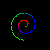

---DECISION: VISION CHECK---
---GENERATING VISION LLM ASSESSMENT---
---DECISION: bypass user, with iteration=2, vision_note=70, vision_improvement=50
================================ Human Message =================================

Your solution is noted by an independent assessor: 70/100. Here is an improvement hint : The painting is mostly colorful and spiralled, but it lacks clear definition and contrast, making it difficult to discern the spiral structure clearly. Improve the contrast and definition of the spiral to better match the description.
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
================================== Ai Message ==================================

Here is my attempt to solve the problem: 
prefix: I will enhance the spiral drawing function to improve the contrast and definition of the spiral structure, ensuring it is more visually distinct. 
imports: import numpy as np 
code: def draw_spiral(shape):
    output = np.zeros(shape, dtype=np.float

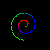

---DECISION: VISION CHECK---
---GENERATING VISION LLM ASSESSMENT---
---DECISION: ask user, as iteration=3 and vision_improvement=0<=0
================================ Human Message =================================

Your solution is noted by an independent assessor: 70/100. Here is an improvement hint : The painting is mostly colorful and spiralled, but it lacks clear definition and contrast, making it difficult to discern the spiral structure clearly. Improve the contrast and definition of the spiral to better match the description.
---USER NOT SATISFIED---
================================ Human Message =================================

Your solution is not perfect yet. Here is a hint: make the branches larger and give a dull color to the backgroud. Reflect on this hint and your prior attempt to improve your solution. (1) State what you think went wrong with the prior solution and (2) try to solve this problem again. Return the FULL SOLUTION. Use the code tool to structure the output

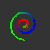

---DECISION: VISION CHECK---
---GENERATING VISION LLM ASSESSMENT---
---DECISION: ask user, as iteration=4 and vision_improvement=0<=0
================================ Human Message =================================

Your solution is noted by an independent assessor: 70/100. Here is an improvement hint : The painting is mostly colorful and spiralled, but it lacks clear definition and contrast, making it difficult to discern the spiral structure. Suggest using more distinct colors and clearer shapes to enhance the spiral effect.
---USER SATISFIED---
---DECISION: FINISH---:user satisfied


In [26]:
_printed=set()
config = {"configurable": {"thread_id": "1"}}
max_iterations = 10
for event in graph.stream({"requested_shape":(50,50,3),
                           "requested_description":"a colorfull spiralled painting","iterations": 0,
                           "vision_note": 0,
                           "vision_improvement": 0,
                           "errors": 0,
                            "user_satisfaction": "no",
                           "messages": [HumanMessage(content="hint: in the code block, define a 'draw_line' function, a 'draw_face' and then a 'draw_cube' function.")]
                           },
                           stream_mode="values",
                           config=config
                           ):
    _print_event(event=event, _printed=_printed, max_length=500)

#### Printing the final state

Last graph state (messages are printed below):


requested_description:
a colorfull spiralled painting
--------------------
requested_shape:
[50, 50, 3]
--------------------
errors:
0
--------------------
messages: see below
--------------------
code_solution_imports:
import numpy as np
--------------------
code_solution_code:
def draw_spiral(shape):
    output = np.zeros(shape, dtype=np.float32)
    # Set a dull background color
    output[:, :] = [0.2, 0.2, 0.2]  # Dark gray background
    center = (shape[0] // 2, shape[1] // 2)
    radius = 1
    thickness = 2  # Increase thickness of the spiral branches
    for angle in range(0, 720, 5):  # Increased angle range for a more complete spiral
        rad = np.radians(angle)
        x_center = int(center[0] + radius * np.cos(rad))
        y_center = int(center[1] + radius * np.sin(rad))
        # Generate vibrant colors using HSV color space
        hue = angle / 720.0  # Normalize angle to [0, 1]
        color = np.array([1, 1, 1]) * n

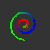

--------------------
vision_note:
70
--------------------
vision_improvement:
0
--------------------

Message history:

hint: in the code block, define a 'draw_line' function, a 'draw_face' and then a 'draw_cube' function. 
--------------------

Here is my attempt to solve the problem: 
prefix: I will create functions to draw a colorful spiral pattern in a numpy array, including functions for drawing lines, faces, and cubes. 
imports: import numpy as np 
code: def draw_line(output, start, end, color):
    # Draw a line in the numpy array us [..........]
--------------------

Your solution is noted by an independent assessor: 20/100. Here is an improvement hint : The image should have vibrant colors and a clear spiral pattern. The current image is too dark and lacks color. 
--------------------

Here is my attempt to solve the problem: 
prefix: I will enhance the spiral drawing function to ensure vibrant colors and a clearer spiral pattern. 
imports: import numpy as np 
code: def draw_l

In [27]:
print("Last graph state (messages are printed below):\n\n")
print("="*100)
for k, v in graph.get_state(config=config).values.items():
    if k!='messages':
        if k=='b64_image':
            print(k)
            display(b64_to_Image(v))
        else:
            print(f"{k}:\n{v}")
    else: 
        print('messages: see below')
    print("-"*20)

print("="*100)
print()
print("Message history:\n")
for m in graph.get_state(config=config).values['messages']:
    print(m.content[:300], "[..........]" if len(m.content)>300 else "")
    print("-"*20)
    print()